# Steel Defect Detection

Steel is one of the most important building materials of modern times. Steel buildings are resistant to natural and man-made wear which has made the material ubiquitous around the world. To help make production of steel more efficient, this competition will help identify defects

### Problem statement :

This competition is a two-fold competition: classify the type of steel defect, and also segment the parts of the image that contain the defect.

### Metrics :

#### Dice coefficient: 

The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mfrac>
    <mrow>
      <mn>2</mn>
      <mo>&#x2217;<!-- ∗ --></mo>
      <mrow class="MJX-TeXAtom-ORD">
        <mo stretchy="false">|</mo>
      </mrow>
      <mi>X</mi>
      <mo>&#x2229;<!-- ∩ --></mo>
      <mi>Y</mi>
      <mrow class="MJX-TeXAtom-ORD">
        <mo stretchy="false">|</mo>
      </mrow>
    </mrow>
    <mrow>
      <mrow class="MJX-TeXAtom-ORD">
        <mo stretchy="false">|</mo>
      </mrow>
      <mi>X</mi>
      <mrow class="MJX-TeXAtom-ORD">
        <mo stretchy="false">|</mo>
      </mrow>
      <mo>+</mo>
      <mrow class="MJX-TeXAtom-ORD">
        <mo stretchy="false">|</mo>
      </mrow>
      <mi>Y</mi>
      <mrow class="MJX-TeXAtom-ORD">
        <mo stretchy="false">|</mo>
      </mrow>
    </mrow>
  </mfrac>
</math>



where X is the predicted set of pixels and Y is the ground truth. The Dice coefficient is defined to be 1 when both X and Y are empty.

### Constraint

### EncodedPixels
In order to reduce the submission file size, metric uses run-length encoding on the pixel values. Instead of submitting an exhaustive list of indices for your segmentation, we will submit pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
from PIL import Image 
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization,Input,Conv2DTranspose
from keras import Model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler,Callback
from tqdm import tqdm_notebook
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

# Exploratory Data Analysis

In [5]:
df = pd.read_csv('/content/train.csv')
df.shape

(50272, 2)

In [6]:
from glob import glob
# set paths to train and test image datasets
TRAIN_PATH = '/content/train_images/'
TEST_PATH = '/content/test_images/'

# load dataframe with train labels
train_fns = sorted(glob(TRAIN_PATH + '*.jpg'))
test_fns = sorted(glob(TEST_PATH + '*.jpg'))

print('There are {} images in the train set.'.format(len(train_fns)))
print('There are {} images in the test set.'.format(len(test_fns)))

There are 12568 images in the train set.
There are 1801 images in the test set.


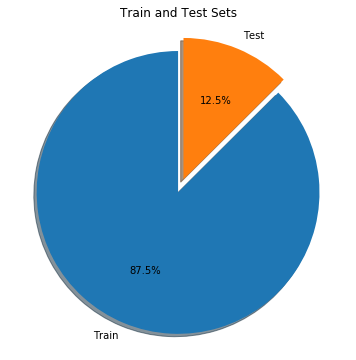

In [7]:
# plotting a pie chart which demonstrates train and test sets
labels = 'Train', 'Test'
sizes = [len(train_fns), len(test_fns)]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Train and Test Sets')

plt.show()

#### How many steel images have disadvantages?

In [8]:
print("Train_df INFO : \n")
print("1.Number of data points : ", len(df))
print("2.Correct images  : ", df["EncodedPixels"].isna().sum().T)
print("3.Incorrect images : ",len(df) - df["EncodedPixels"].isna().sum().T )

Train_df INFO : 

1.Number of data points :  50272
2.Correct images  :  43177
3.Incorrect images :  7095


#### About 7095 images posses disadvantages

#### How many classes are assigned to a single photo? It's single or multilabel segmentation problem ?

In [9]:
# add new features from existing one
df["Label"] = df["ImageId_ClassId"].apply(lambda x : x.split("_")[1])
df["Image_id"] = df["ImageId_ClassId"].apply(lambda x : x.split("_")[0])
df.head(2)

,ImageId_ClassId,EncodedPixels,Label,Image_id
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1,0002cc93b.jpg
1,0002cc93b.jpg_2,NaN,2,0002cc93b.jpg


In [10]:
#data without nans
train_df_damaged = df[df["EncodedPixels"].notnull()]
train_df_damaged.head()

,ImageId_ClassId,EncodedPixels,Label,Image_id
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1,0002cc93b.jpg
18,0007a71bf.jpg_3,18661 28 18863 82 19091 110 19347 110 19603 11...,3,0007a71bf.jpg
20,000a4bcdd.jpg_1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,1,000a4bcdd.jpg
27,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,4,000f6bf48.jpg
30,0014fce06.jpg_3,229501 11 229741 33 229981 55 230221 77 230468...,3,0014fce06.jpg


Numeric info : 

1 class :  6239
2 classes :  425
3 classes :  2
4 classes :  0


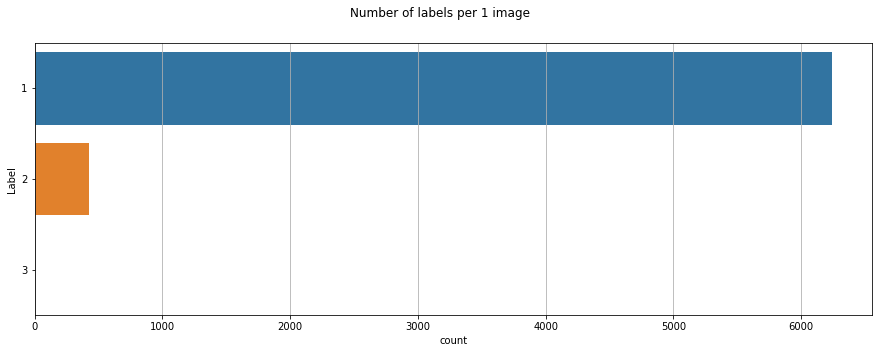

In [11]:
n_class_per_image =  train_df_damaged["Label"].groupby(train_df_damaged["Image_id"]).count()
plt.figure(figsize=(15,5))
plt.suptitle("Number of labels per 1 image")
plt.grid()
import seaborn as sns
sns.countplot(y=n_class_per_image)
print("Numeric info : \n")
print("1 class : ",len(n_class_per_image[n_class_per_image == 1]))
print("2 classes : ",len(n_class_per_image[n_class_per_image == 2]))
print("3 classes : ",len(n_class_per_image[n_class_per_image == 3]))
print("4 classes : ",len(n_class_per_image[n_class_per_image == 4]))

Most n_classes per image = 1

Least n_classes per image = 3

Max n_classes per image = 3

At this context we struggle with multilabel segmentation

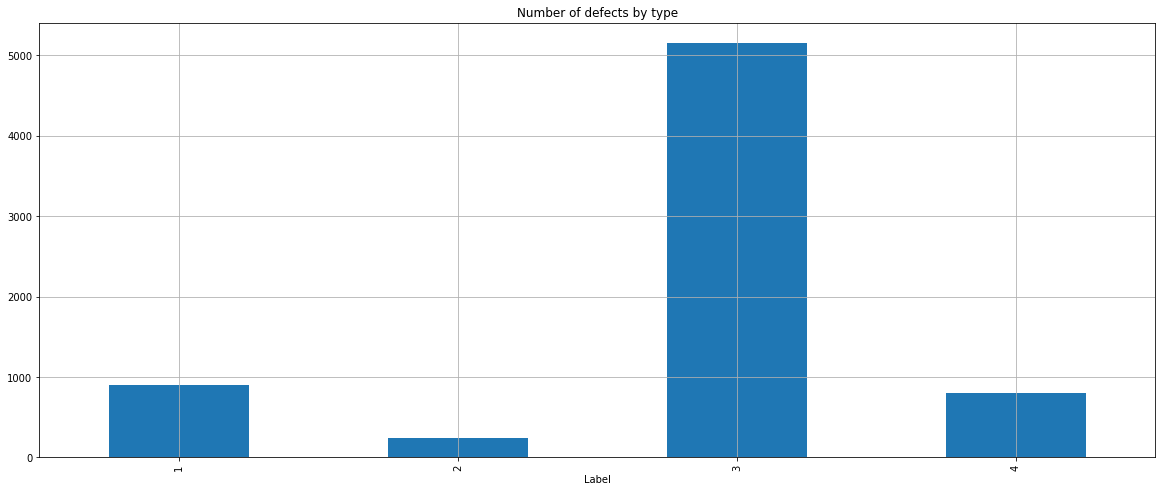

In [12]:
df.groupby('Label')['EncodedPixels'].count().plot(kind='bar',
                                                            title='Number of defects by type', 
                                                            figsize=(20, 8),
                                                            grid=True);

In [13]:
print('There are {} rows with empty segmentation maps.'.format(len(df) - df.EncodedPixels.count()))

There are 43177 rows with empty segmentation maps.


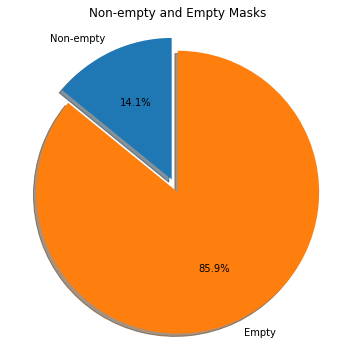

In [14]:
# plotting a pie chart
labels = 'Non-empty', 'Empty'
sizes = [df.EncodedPixels.count(), len(df) - df.EncodedPixels.count()]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Non-empty and Empty Masks')

plt.show()

In [15]:
# split column
split_df = df["ImageId_ClassId"].str.split("_", n = 1, expand = True)

# add new columns to train_df
df['Image'] = split_df[0]
df['Label'] = split_df[1]

# check the result
df.head()

,ImageId_ClassId,EncodedPixels,Label,Image_id,Image
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1,0002cc93b.jpg,0002cc93b.jpg
1,0002cc93b.jpg_2,NaN,2,0002cc93b.jpg,0002cc93b.jpg
2,0002cc93b.jpg_3,NaN,3,0002cc93b.jpg,0002cc93b.jpg
3,0002cc93b.jpg_4,NaN,4,0002cc93b.jpg,0002cc93b.jpg
4,00031f466.jpg_1,NaN,1,00031f466.jpg,00031f466.jpg


In [16]:
defect1 = df[df['Label'] == '1'].EncodedPixels.count()
defect2 = df[df['Label'] == '2'].EncodedPixels.count()
defect3 = df[df['Label'] == '3'].EncodedPixels.count()
defect4 = df[df['Label'] == '4'].EncodedPixels.count()

print('There are {} defect1 images'.format(defect1))
print('There are {} defect2 images'.format(defect2))
print('There are {} defect3 images'.format(defect3))
print('There are {} defect4 images'.format(defect4))
print('There are {} images with no defects'.format(len(train_fns) - defect1 - defect2 - defect3 - defect4))

There are 897 defect1 images
There are 247 defect2 images
There are 5150 defect3 images
There are 801 defect4 images
There are 5473 images with no defects


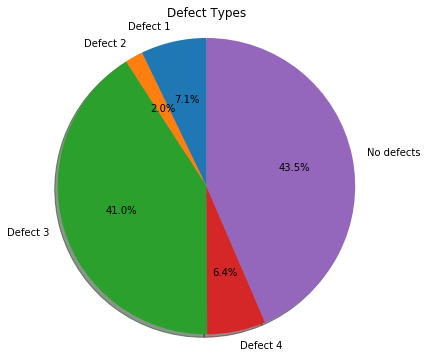

In [17]:
# plotting a pie chart
labels = 'Defect 1', 'Defect 2', 'Defect 3', 'Defect 4', 'No defects'
sizes = [defect1, defect2, defect3, defect4, len(train_fns) - defect1 - defect2 - defect3 - defect4]

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Defect Types')

plt.show()

Conclusions:

The dataset is very imbalanced.

Data augmentation and resampling techniques will be required to perform the defect detection.

In [18]:
labels_per_image = df.groupby('Image')['EncodedPixels'].count()
print('The mean number of labels per image is {}'.format(labels_per_image.mean()))

The mean number of labels per image is 0.564528962444303


Text(0.5, 1.0, 'Number of Labels per Image')

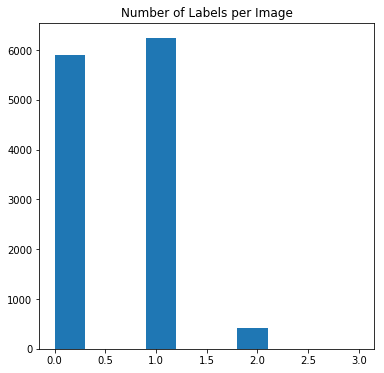

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(labels_per_image)
ax.set_title('Number of Labels per Image')

#### Conclusions:

Almost half of images doesn't contain any defects;

Most of images with defects contain the defects of only one type;

In rare cases an image contains the defects of two different types.

# preprocessing data

In [20]:
df['ImageId'] = df['ImageId_ClassId'].map(lambda x : x.split(".")[0]+'.jpg') # This will take id after interval of 4 rows.
train = pd.DataFrame({'ImageId':df['ImageId'][0::4]}) # Creating dataframe with image names of images
train['e1'] = df['EncodedPixels'][0::4].values # Will take encoding after interval of 4.
train['e2'] = df['EncodedPixels'][1::4].values
train['e3'] = df['EncodedPixels'][2::4].values
train['e4'] = df['EncodedPixels'][3::4].values
train.reset_index(inplace=True, drop=True)
train.fillna('', inplace=True)
train.head()

,ImageId,e1,e2,e3,e4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [0]:
train_df = train.iloc[:int(0.80*len(train))]
test_df = train.iloc[int(0.80*len(train)):int(0.9*len(train))]
cv_df = train.iloc[int(0.9*len(train)):]

In [22]:
print(train_df.shape)
print(test_df.shape)
print(cv_df.shape)

(10054, 5)
(1257, 5)
(1257, 5)


In [0]:
import numpy as np
def rle2mask(rle):
  # If rle is empty or null
  if(len(rle)<1): 
    return np.zeros((128,800) ,dtype=np.uint8)
    
  height = 256
  width = 1600
  
  # Defining the length of mask. This will be 1d array and later will be reshaped to 2d.
  mask = np.zeros(height*width ).astype(np.uint8)
  # We will have an array that wil contain rle
  array = np.asarray([int(x) for x in rle.split()])
  start = array[0::2]-1 # this willl contain the start of run length
  length = array[1::2] # this will contain the length of each rle.
  '''
    pixels = np.array((0, 1, 1, 1, 1, 0, 0, 0, 1))

    # Concatenating a zero at the start and end of the array is to
    # make sure that the first changing is always from 0 to 1
    pixels = np.concatenate([[0], pixels, [0]])
    print('pixels:', pixels)

    # the array except the first element
    print('pixels[1:]:', pixels[1:])
    # the array except the last element
    print('pixels[:-1]:', pixels[:-1])

    # runs include indices to wherever 0s change to 1s or 1s change to 0s
    print('where condition:', pixels[1:] != pixels[:-1])
    runs = np.where(pixels[1:] != pixels[:-1])
    print('runs:', runs)

    # the purpose of adding 1 here is to make sure that the indices point to
    # the very first 1s or 0s of the 1s or 0s, this is needed because
    # np.where gets the indices of elements before changing
    runs = runs[0] + 1
    print('runs = runs[0] + 1:', runs)

    # runs[1::2] --> runs[start:stop:step], thus 2 here is the step
    # thus runs[1::2] includes the indices of the changing from 1 to 0
    print('runs[1::2]:', runs[1::2])

    # runs[::2] includes the indices for the changing from 0 to 1
    print('runs[::2]:', runs[::2])

    # the length of 1s
    print('runs[1::2]-runs[::2]:', runs[1::2] - runs[::2])

    # replace runs[1::2] with the lengths of consecutive 1s
    runs[1::2] -= runs[::2]

    print('return:', ' '.join(str(x) for x in runs))
    
    Output:
    pixels: [0 0 1 1 1 1 0 0 0 1 0]
    pixels[1:]: [0 1 1 1 1 0 0 0 1 0]
    pixels[:-1]: [0 0 1 1 1 1 0 0 0 1]
    where condition: [False  True False False False  True False False  True  True]
    runs: (array([1, 5, 8, 9]),)
    runs = runs[0] + 1: [ 2  6  9 10]
    runs[1::2]: [ 6 10]
    runs[::2]: [2 9]
    runs[1::2]-runs[::2]: [4 1]
    return: 2 4 9 1
    
  '''
  #  now we will chane the value of each pixel in the rle to 1.
  for i,start in enumerate(start):
    mask[int(start):int(start+length[i])] = 1
    
    '''
    width=4, height=3
    
    s = [1,2,3,4,5,6,7,8,9,10,11,12]

    s.reshape(4,3) :
    [[ 1  2  3]
     [ 4  5  6]
     [ 7  8  9]
     [10 11 12]]

    s.reshape(4,3).T :
    [[ 1  4  7 10]
     [ 2  5  8 11]
     [ 3  6  9 12]]
    '''
    
  # now we will return the mask by first reshaping it and then rotating by 90 degrees and the vertically flipping it upside down.
  #return np.flipud(np.rot90(mask.reshape(width, height), k=1)) # Here k=1 means we will rotate only once.
  return mask.reshape( (height,width), order='F' )[::2,::2]

In [0]:
    def mask2rle(img):
        '''
        img: numpy array, 1 - mask, 0 - background
        Returns run length as string formated
        '''
        #print(img.shape)
        pixels= img.T.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        return ' '.join(str(x) for x in runs)

In [ ]:
    '''
    mask_rle = ' '.join(str(x) for x in runs)
    s = mask_rle.split()
    print('s:', s)

    print('s[0:][::2]:', s[0:][::2])
    assert(s[0:][::2] == s[::2])

    print('s[1:][::2]:', s[1:][::2])
    assert(s[1:][::2] == s[1::2])

    starts = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    print('starts:', starts)

    rle_decode(mask_rle, (1, 9))
    
    
    output:
    s: ['2', '4', '9', '1']
    s[0:][::2]: ['2', '9']
    s[1:][::2]: ['4', '1']
    starts: [array([2, 9]), array([4, 1])]
    array([[0, 1, 1, 1, 1, 0, 0, 0, 1]], dtype=uint8)
    '''

### Data Augmentation

In [0]:
import keras
from keras.preprocessing.image import ImageDataGenerator
class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        
        if self.subset == "train":
            self.data_path = '/content/' + 'train_images/'
        elif self.subset == "test":
            self.data_path = '/content/' + 'train_images/'
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    #fliping the images horizontally and samplewise std normalization
    def __getitem__(self, index):
        train_datagen = ImageDataGenerator()
        param = {'flip_horizontal':True, 'samplewise_std_normalization' : True}
        
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            img = Image.open(self.data_path + f).resize((800,128))
            X[i,] = train_datagen.apply_transform(x = img, transform_parameters = param)
            if self.subset == 'train': 
                #run-length encoding on the pixel values
                for j in range(4):
                    mask = rle2mask(self.df['e'+str(j+1)].iloc[indexes[i]])
                    y[i,:,:,j] = train_datagen.apply_transform(x = mask, transform_parameters = param)
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X

In [0]:
from keras import backend as K
from keras.losses import binary_crossentropy
# Competetion Metric
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  
def  bce_dice_loss(y_true, y_predict):
  return binary_crossentropy(y_true, y_predict) + (1-dice_coef(y_true, y_predict))

# Final model

In [28]:
    inputs = Input((128,800,3)) # 256
    down = Conv2D(32, (3, 3), padding='same')(inputs)
    down = BatchNormalization()(down)
    down = Activation('relu')(down)
    down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down) #128
    center = Conv2D(128, (3, 3), padding='same')(down_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center) # center
    up = UpSampling2D((2, 2))(center)
    up = concatenate([down, up], axis=3)
    up = Conv2D(32, (3, 3), padding='same')(up)
    up = BatchNormalization()(up)
    up = Activation('relu')(up) # 256
    classify = Conv2D(4, (1, 1), activation='sigmoid')(up)
    model = Model(inputs=inputs, outputs=classify)
    model.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy',dice_coef])










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
train_batches = DataGenerator(train_df,shuffle=True)
valid_batches = DataGenerator(cv_df)
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 20, verbose=1)

Epoch 1/20
628/628 [==============================] - 388s 619ms/step - loss: 0.0997 - acc: 0.9827 - dice_coef: 0.0321 - val_loss: 0.0410 - val_acc: 0.9928 - val_dice_coef: 0.0212
Epoch 2/20
628/628 [==============================] - 382s 608ms/step - loss: 0.0355 - acc: 0.9922 - dice_coef: 0.0760 - val_loss: 0.0345 - val_acc: 0.9929 - val_dice_coef: 0.0642
Epoch 3/20
628/628 [==============================] - 379s 603ms/step - loss: 0.0327 - acc: 0.9923 - dice_coef: 0.1053 - val_loss: 0.0367 - val_acc: 0.9918 - val_dice_coef: 0.0938
Epoch 4/20
628/628 [==============================] - 379s 604ms/step - loss: 0.0314 - acc: 0.9924 - dice_coef: 0.1254 - val_loss: 0.0299 - val_acc: 0.9931 - val_dice_coef: 0.1306
Epoch 5/20
628/628 [==============================] - 383s 609ms/step - loss: 0.0307 - acc: 0.9925 - dice_coef: 0.1354 - val_loss: 0.0296 - val_acc: 0.9931 - val_dice_coef: 0.1336
Epoch 6/20
628/628 [==============================] - 380s 606ms/step - loss: 0.0302 - acc: 0.9925 -

In [0]:
from keras.models import load_model

model.save('model1.h5')

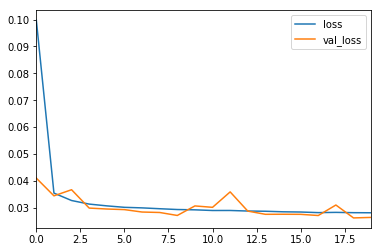

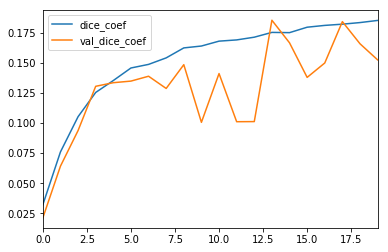

In [0]:
import json
with open('history.json','w') as f:
  json.dump(history.history, f)            
  history_df = pd.DataFrame(history.history)
  history_df[['loss', 'val_loss']].plot()
  history_df[['dice_coef', 'val_dice_coef']].plot()

In [0]:
test_batches = DataGenerator(test_df, subset='test',batch_size=1)
preds = model.predict_generator(test_batches,verbose=1)

1257/1257 [==============================] - 25s 20ms/step


In [0]:
# Predicting on test data
from tqdm import tqdm
data_path = '/content/' + 'test_images/'
files = list(os.listdir(data_path))
img_classId = []
rle_lst = []
for f in files:
  X = np.empty((1,128,800,3),dtype=np.float32)
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  X[0,] = img
  mask = model.predict(X)
  #print(mask[0,:,:,1].shape)
  rle_m = np.empty((128,800),dtype=np.uint8)
  for i in range(4):
    rle_m = mask[0,:,:,i].round().astype(int)
    rle = mask2rle(rle_m)
    rle_lst.append(rle)
    img_classId.append(f+'_'+str(i+1))

In [0]:
output = {'ImageId_ClassId':img_classId, 'EncodedPixels' : rle_lst}
import pandas as pd
output_df = pd.DataFrame(output)
output_df.to_csv('submission.csv', index=False)

# Conclusion

 classified the type of steel defect,segmented the parts of the image that contain the defect and achieved Dice coefficient of less than 0.09